# CSUMB Diagnostics Lab Tool Development

YOU and you're team are bioinformaticians for a clinical lab that performs diagnostic testing for the early, and accurate, detection of differentially expressed oncogenes and known oncogenic mutations.

Today, you're tasked with developing some software that can automate the quantification of gene expression and the detection of variants from RNA-sequencing data.

Case-study data has been deposited in the organizational database: `drive/Shareddrives/CSUMB-GREAT` where you can access it to help you develop these tools.

## Loading reference sequences (FASTA) into Python

In [7]:
# this DICTIONARY will hold
# genes as KEYS
# sequences as VALUES
reference_dictionary = {}

# with the file connection set to our reference FASTA ... 
with open("/Users/vikas/Downloads/CSUMB_reference/three_gene_ref.fa") as reference:
        header = '' # create empty string for headers
        sequence = '' # create empty string for sequences

        for line in reference:
            if line.startswith('>'):
                header = line[1:].rstrip()
                sequence = ''
            else:
                sequence += ''.join(line.rstrip().split()).upper()
            reference_dictionary[header] = sequence

In [8]:
for gene, sequence in reference_dictionary.items():
  print(gene, len(sequence)/1000, 'kb')

CDH1 4.811 kb
KRAS 5.43 kb
TP53 2.512 kb


## Loading Alignments (SAM) into Python

The `.sam` alignment files are stored in `/media/fileshare/aligned_data/{KRAS, CDH1, TP53}`

In [9]:
%ls /media/fileshare/CSUMB_aligned_data/*/pair_1 | head

ls: /media/fileshare/CSUMB_aligned_data/*/pair_1: No such file or directory


We can also use some `bash` commands by pre-pending them with `!`, for example let's look at one of the alignment (.sam) files and think about which lines we need to load and which we need to skip

In [10]:
!head /media/fileshare/CSUMB_aligned_data/KRAS/pair_3/pair_3.sam

head: /media/fileshare/CSUMB_aligned_data/KRAS/pair_3/pair_3.sam: No such file or directory


### And now,

Lets write the code.

I'm providing the destination object: `alignment_dictionary` that you will populate with `read_id`'s, `read_start` positions, and `read_sequence`'s

Use the `FASTA` parser code above as inspiration to implement an approach that reads the `SAM` files line-by-line and stores the relevant information in `alignment_dictionary`

In [3]:
alignment_dictionary = {}
# keys: read_id
# values: tuple(start position of alignment, sequence of aligned read)

# define an object to hold the name of the SAM file you want to load
pre_path = '/Users/vikas/Downloads/CSUMB_aligned_data/' # this part of the path is constant; all .sams are here

gene = 'KRAS' # gene is defined as you need it
#gene = 'TP53'
#gene = 'CDH1'

pair = 'pair_1' # pair is defined as you need it

# then, we stitch all of these strings together with `+` and creat a full path
input_sam = pre_path + '/' + gene + '/' + pair + '/' + pair + ".sam" # pick one .sam for now...
# ex. /media/fileshare/aligned_data/KRAS/pair_3/pair_3.sam

print('loading ' + input_sam + ' into aligment dictionary')

# start here, test and try things, populate the dictionary
with open(input_sam) as alignment:
        for line in alignment:
            split_line = line.split()
            if '@' not in split_line[0]:
                alignment_dictionary[split_line[0]] = split_line

loading /Users/vikas/Downloads/CSUMB_aligned_data//KRAS/pair_1/pair_1.sam into aligment dictionary


Explore `alignment_dictionary` by printing its keys. Print the value of the first key thats printed. 

In [4]:
print(alignment_dictionary.keys())
print(alignment_dictionary['80728'])

dict_keys(['80728', '151046', '883336', '269290', '227638', '69729', '109856', '456896', '126007', '364540', '113958', '564302', '924445', '203052', '28636', '567695', '624068', '106884', '610167', '719950', '908656', '756460', '79071', '867381', '967686', '477725', '449804', '365913', '95271', '910886', '413671', '230814', '331455', '472458', '931256', '825871', '612618', '179814', '780312', '518323', '31434', '836155', '895456', '911452', '258394', '182513', '698545', '40774', '212714', '733313', '797982', '560484', '46895', '907817', '951504', '151697', '269226', '861752', '270141', '515192', '627538', '91925', '413055', '928348', '314268', '169353', '239308', '175136', '553818', '997868', '114799', '209355', '952084', '484167', '474407', '190403', '556800', '57998', '634107', '152538', '406486', '776963', '923122', '563853', '348322', '534578', '71783', '828399', '28756', '6921', '825156', '670571', '336680', '895630', '806807', '719567', '956314', '413515', '100020', '574740', '43

# Exercises

## Exercise #1

Calculate the number of reads aligned to the reference and the size of your reference gene
  - Determine how many reads we have aligned to our reference if possible, compare to the bowtie output and remember that in this special case, we're aligning to only one gene
  - store this in the variable "read_count"
hint:
  - we want to measure how many entries are in our alignment obj...

In [5]:
read_count = len(alignment_dictionary)
print(read_count)

8000


## Exercise #2

Calculate the number of reads aligned to the reference per-kilobase length of gene
  - Scale / normalize the read abundance to the size of the gene and answer: **why are we doing this**?
  

hint:
  - reuse `read_count`

In [8]:
cdh1_length = len(reference_dictionary['CDH1'])

print(read_count / cdh1_length)

1.6628559551028892


## Exercise #3

Calculate per-nucleotide coverage across target gene
  - for every position in the reference, determine the number of reads that overlap that position

hint:
  - Python is 0-based (refer to primer) but the reference sequence is not

extra credit:
  - using `max(dictionary, key=dictionary.get)` determine the position, and coverage that is the maximum (do the same for `min`) across the reference

In [19]:
import pandas as pd

positions_dict = {}
for record in alignment_dictionary.keys():
    record_start = int(alignment_dictionary[record][3]) 
    record_length = len(alignment_dictionary[record][9])
    for i in range(record_start, record_start + record_length):
        if i not in positions_dict:
            positions_dict[i] = 1 
        else: 
            positions_dict[i] += 1

print('max ' + str(positions_dict[max(positions_dict, key=positions_dict.get)]))
print('min ' + str(positions_dict[min(positions_dict, key=positions_dict.get)]))
#print(positions_dict)


max 204
min 4
1 4


## Exercise #4

Calculate SNP-aware per-nucleotide coverage of target reference
  - for every position in the reference,determine the number of reads that overlap that position with the expected, matching nucleotide as well as the number of reads that contain single-nucleotide polymorphisms (SNPs)

hint:
  - re-use as much code as possible....

extra credit:
  - calculate the "allele frequency" at positions with
  - mutations, where `AF = reference observed / total observations`

In [10]:
mutation_dict = {}
gene = 'KRAS'
for record in alignment_dictionary.keys():
    record_start = int(alignment_dictionary[record][3]) 
    record_length = len(alignment_dictionary[record][9])
    record_seq = alignment_dictionary[record][9]
    for i in range(0, record_length):
        position = i + record_start -1
        if position not in mutation_dict:
            if record_seq[i] == reference_dictionary[gene][position]:
                mutation_dict[position] = [0,1]
            else: 
                mutation_dict[position] = [1,0]
        else:
            if record_seq[i] == reference_dictionary[gene][position]:
                mutation_dict[position][1] = mutation_dict[position][1] + 1
            else: 
                mutation_dict[position][0] = mutation_dict[position][0] + 1

AF_dict = {}
for position in mutation_dict.keys():
    position_coverage = mutation_dict[position][0] + mutation_dict[position][1]
    AF_dict[position] = mutation_dict[position][0] / position_coverage
print(AF_dict)
print(max(AF_dict, key=AF_dict.get))
print(AF_dict[223])



{4584: 0.0, 4585: 0.0, 4586: 0.0, 4587: 0.0, 4588: 0.0, 4589: 0.0, 4590: 0.0, 4591: 0.0, 4592: 0.0, 4593: 0.0, 4594: 0.0, 4595: 0.0, 4596: 0.0, 4597: 0.0, 4598: 0.0, 4599: 0.0, 4600: 0.0, 4601: 0.0, 4602: 0.0, 4603: 0.0, 4604: 0.0, 4605: 0.0, 4606: 0.0, 4607: 0.0, 4608: 0.0, 4609: 0.0, 4610: 0.0, 4611: 0.0, 4612: 0.0, 4613: 0.0, 4614: 0.0, 4615: 0.0, 4616: 0.0, 4617: 0.0, 4618: 0.0, 4619: 0.0, 4620: 0.0, 4621: 0.0, 4622: 0.0, 4623: 0.0, 4624: 0.0, 4625: 0.0, 4626: 0.0, 4627: 0.0, 4628: 0.0, 4629: 0.0, 4630: 0.0, 4631: 0.0, 4632: 0.0, 4633: 0.0, 4634: 0.0, 4635: 0.0, 4636: 0.0, 4637: 0.0, 4638: 0.0, 4639: 0.0, 4640: 0.0, 4641: 0.0, 4642: 0.0, 4643: 0.0, 4644: 0.0, 4645: 0.0, 4646: 0.0, 4647: 0.0, 4648: 0.0, 4649: 0.0, 4650: 0.0, 4651: 0.0, 4652: 0.0, 4653: 0.0, 4654: 0.0, 4655: 0.0, 4656: 0.0, 4657: 0.0, 4658: 0.0, 928: 0.0, 929: 0.0, 930: 0.0, 931: 0.0, 932: 0.0, 933: 0.0, 934: 0.0, 935: 0.0, 936: 0.0, 937: 0.0, 938: 0.0, 939: 0.0, 940: 0.0, 941: 0.0, 942: 0.0, 943: 0.0, 944: 0.0, 945:

If your dictionary is correct, replace the variable YOUR_DICTIONAEY_HERE below with your dictionary and a graph should be produced: 

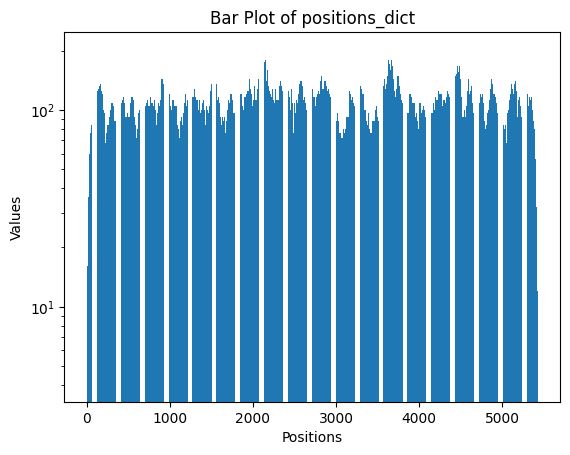

In [20]:
import matplotlib.pyplot as plt

# Extract the keys and values from positions_dict
keys = list(positions_dict.keys())
values = list(positions_dict.values())

# Create the bar plot
plt.bar(keys, values)

# Set labels and title
plt.xlabel('Positions')
plt.ylabel('Values')
plt.title('Bar Plot of positions_dict')


# Set y-axis to logarithmic scale
plt.yscale('log')

# Show the plot
plt.show()

## Exercise #5

Generalize your approach to work on all of the generated SAM files
  * Create two functions: 
    * 1) Read each SAM file into an alignment dictionary. Store the dictionary in another dictionary where the key is the sample name, and the value is the alignment dictionary
    * 2) Process the SAM file to do the following:
  * For each file and its corresponding reference, print the position with the highest Allele fraction in the following format: 
      * "Pair 1/2/3 from gene A had an allele fraction of B for gene C at position D"
      
hint: you can modify the following if statement to check if a file exists: 
* if os.path.exists(file_path):

In [21]:
import os
pre_path = '/Users/vikas/Downloads/CSUMB_aligned_data/' # this part of the path is constant; all .sams are here

genes = ['KRAS','TP53','CDH1'] # gene is defined as you need it

pairs = ['pair_1','pair_2','pair_3', 'pair_4', 'pair_5'] # pair is defined as you need it

def read_sam(input_sam):
    # ex. /media/fileshare/aligned_data/KRAS/pair_3/pair_3.sam
    alignment_dictionary = {}
    print('loading ' + input_sam + ' into aligment dictionary')
    # start here, test and try things, populate the dictionary
    with open(input_sam) as alignment:
            for line in alignment:
                split_line = line.split()
                if '@' not in split_line[0]:
                    alignment_dictionary[split_line[0]] = split_line
    return(alignment_dictionary)


def calculate_AF(alignment_dict, gene, reference_dictionary):
    mutation_dict = {}
    for record in alignment_dict.keys():
        record_start = int(alignment_dict[record][3]) 
        record_length = len(alignment_dict[record][9])
        record_seq = alignment_dict[record][9]
        for i in range(0, record_length):
            position = i + record_start -1
            if position not in mutation_dict:
                if record_seq[i] == reference_dictionary[gene][position]:
                    mutation_dict[position] = [0,1]
                else: 
                    mutation_dict[position] = [1,0]
            else:
                if record_seq[i] == reference_dictionary[gene][position]:
                    mutation_dict[position][1] = mutation_dict[position][1] + 1
                else: 
                    mutation_dict[position][0] = mutation_dict[position][0] + 1

    AF_dict = {}
    for position in mutation_dict.keys():
        position_coverage = mutation_dict[position][0] + mutation_dict[position][1]
        AF_dict[position] = mutation_dict[position][0] / position_coverage
    highest_af_position = max(AF_dict, key=AF_dict.get)
    highest_af = AF_dict[highest_af_position]
    return(highest_af_position, highest_af)

sam_files = {}
for gene in genes:
    for pair in pairs:
        sam_path = pre_path + '/' + gene + '/' + pair + '/' + pair + ".sam"
        if os.path.exists(sam_path):
            sam_files[gene + '_' + pair] = read_sam(sam_path)
            AF_value = calculate_AF(sam_files[gene + '_' + pair], gene, reference_dictionary)
            print('Pair ' + pair + ' from gene ' + gene + ' had an allele fraction of ' + str(AF_value[1]) + ' for gene ' + gene + ' at position ' + str(AF_value[0]))




loading /Users/vikas/Downloads/CSUMB_aligned_data//KRAS/pair_1/pair_1.sam into aligment dictionary
Pair pair_1 from gene KRAS had an allele fraction of 0.0 for gene KRAS at position 4584
loading /Users/vikas/Downloads/CSUMB_aligned_data//KRAS/pair_2/pair_2.sam into aligment dictionary
Pair pair_2 from gene KRAS had an allele fraction of 0.38636363636363635 for gene KRAS at position 223
loading /Users/vikas/Downloads/CSUMB_aligned_data//KRAS/pair_3/pair_3.sam into aligment dictionary
Pair pair_3 from gene KRAS had an allele fraction of 0.6538461538461539 for gene KRAS at position 223
loading /Users/vikas/Downloads/CSUMB_aligned_data//KRAS/pair_4/pair_4.sam into aligment dictionary
Pair pair_4 from gene KRAS had an allele fraction of 0.85 for gene KRAS at position 223
loading /Users/vikas/Downloads/CSUMB_aligned_data//KRAS/pair_5/pair_5.sam into aligment dictionary
Pair pair_5 from gene KRAS had an allele fraction of 1.0 for gene KRAS at position 223
loading /Users/vikas/Downloads/CSUMB_